In [1]:
%load_ext autoreload
%autoreload 2

# add modules from parent package
import sys
sys.path.append('..')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

## Multi–Armed Bandit for Pricing

In this notebook I implement the ["Multi–Armed Bandit for Pricing" paper](https://ewrl.files.wordpress.com/2015/02/ewrl12_2015_submission_23.pdf)

### Demand modelling

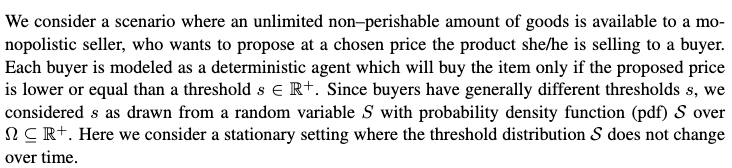

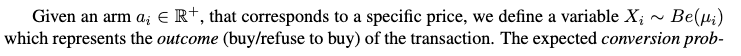
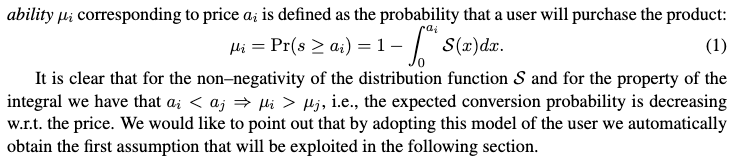

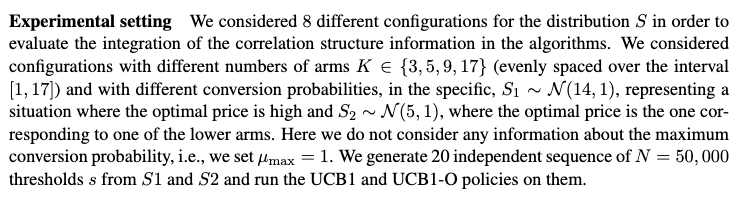

basically:
1. Get pdf of S
2. Each arm has price $a_i$ associated with it.
3. If we pull arm $i$, then we would receive $X_i \sim Be(\mu_i)$, $\mu_i=1-P(s \le a_i)$$

So we can implement it wrapping the `BernoulliBandit`

I can also use **exponential** distribution for better modelling

### Simulations

In [3]:
import itertools

import scipy.stats as ss
from joblib import Parallel, delayed

from bandits.pricing.bandits import PricingBernoulliBandit
from bandits.pricing.agents import UCB1OAgent

from bandits.agents import EpsilonGreedyAgent, UCB1Agent, ThompsonSamplingBetaAgent

In [4]:
np.random.seed(2)
N_SIMULATIONS = 10
T = 2000

eps = 1e-2  # probability of exploration
alpha = 1

In [5]:
p_min = 0
p_max = 10
K = 9
dist_mean = 5
dist_std = 2  # note: I increased it to 6
dist = ss.norm(loc=dist_mean, scale=dist_std)

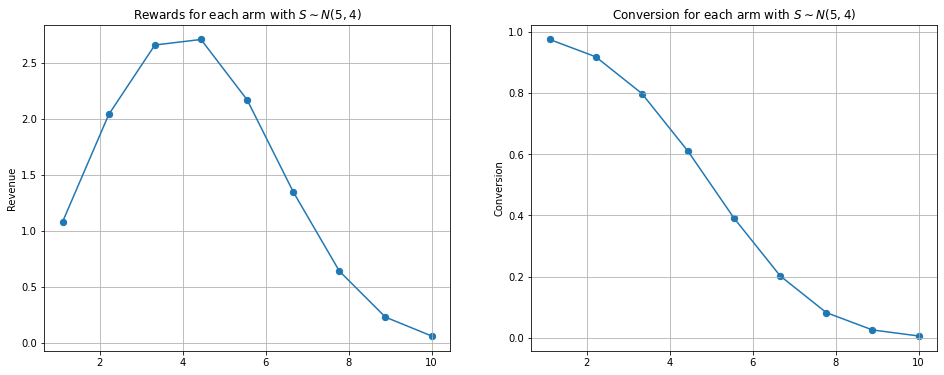

In [6]:
fig,axs=plt.subplots(figsize=(16, 6))

plt.subplot(1, 2, 1)
arms = np.linspace(p_min, p_max, K+1)[1:]
mus = 1-dist.cdf(arms)
rewards = arms*mus
plt.plot(arms, rewards)
plt.scatter(arms, rewards, s=40)
# plt.xticks(arms)
plt.grid()
plt.ylabel('Revenue')
plt.title('Rewards for each arm with $S \sim N(5, 4)$');

plt.subplot(1, 2, 2)
plt.plot(arms, mus)
plt.scatter(arms, mus, s=40)
# plt.xticks(arms)
plt.grid()
plt.ylabel('Conversion')
plt.title('Conversion for each arm with $S \sim N(5, 4)$');

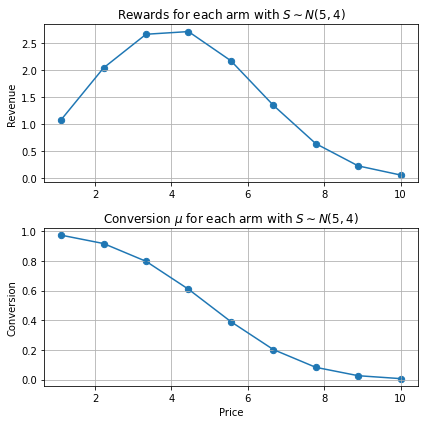

In [8]:
fig,axs=plt.subplots(figsize=(6, 6))

plt.subplot(2, 1, 1)
arms = np.linspace(p_min, p_max, K+1)[1:]
mus = 1-dist.cdf(arms)
rewards = arms*mus
plt.plot(arms, rewards)
plt.scatter(arms, rewards, s=40)
# plt.xticks(arms)
plt.grid()
plt.ylabel('Revenue')
plt.title('Rewards for each arm with $S \sim N(5, 4)$');

plt.subplot(2, 1, 2)
plt.plot(arms, mus)
plt.scatter(arms, mus, s=40)
# plt.xticks(arms)
plt.grid()
plt.ylabel('Conversion')
plt.xlabel('Price')
plt.title('Conversion $\mu$ for each arm with $S \sim N(5, 4)$')
fig.tight_layout();

In [519]:
agents = {
    "UCB1": lambda bandit: UCB1Agent(bandit=bandit, alpha=alpha, reward_normalization=p_max),
    "UCB1-O": lambda bandit: UCB1OAgent(bandit=bandit, alpha=alpha),
}

In [520]:
np.random.seed(1)
agent_to_regret = {name: [] for name in agents.keys()}

for n_simulation in tqdm(range(N_SIMULATIONS)):
    for name, agent_func in agents.items():
        np.random.seed(n_simulation)
        bandit = PricingBernoulliBandit(K=K, dist=dist, p_min=p_min, p_max=p_max)
        agent = agent_func(bandit)
        for t in range(T):
            agent.take_action()
        agent_to_regret[name].append(np.max(arms*bandit.mus) - agent.reward_history)

  0%|          | 0/10 [00:00<?, ?it/s]

In [535]:
ucb1_regret_cumsum = np.cumsum(np.mean(agent_to_regret['UCB1'], axis=0))
ucb1o_regret_cumsum = np.cumsum(np.mean(agent_to_regret['UCB1-O'], axis=0))
relative_regret = ucb1o_regret_cumsum/ucb1_regret_cumsum

# removing the first observations for numerical stability
relative_regret = relative_regret[100:]

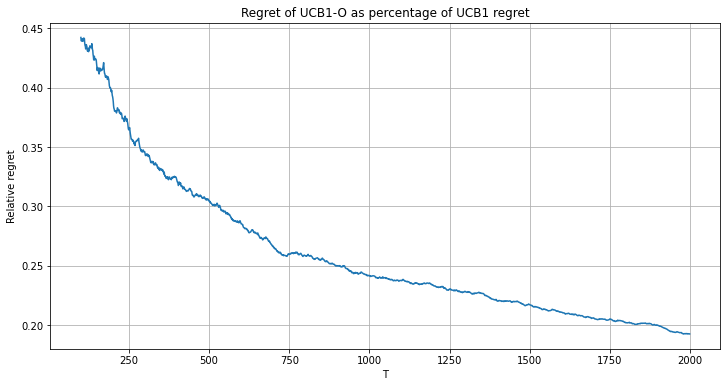

In [538]:
fig,axs=plt.subplots(figsize=(12, 6))
ts = np.arange(100, T)
plt.plot(ts, relative_regret)
plt.xlabel('T')
plt.ylabel('Relative regret')
plt.title('Regret of UCB1-O as percentage of UCB1 regret')
plt.grid();

> parallel computation

the sequential takes too much time for a large number of iterations

In [556]:
np.random.seed(2)
N_SIMULATIONS = 20
T = 2000

eps = 1e-2  # probability of exploration
alpha = 1

In [557]:
p_min = 1
p_max = 17
K = 9
dist_mean = 5
dist_std = 1  # note: I increased it to 6
dist = ss.norm(loc=dist_mean, scale=dist_std)

In [558]:
def simulate_agent(agent_tuple, rng_seed=1):
    np.random.seed(rng_seed+1)
    bandit = bandit = PricingBernoulliBandit(K=K, dist=dist, p_min=p_min, p_max=p_max)
    
    name, agent_func = agent_tuple
    agent = agent_func(bandit)

    for t in range(T):
        agent.take_action()
    regret = np.max(arms*bandit.mus) - agent.reward_history
    return rng_seed, name, regret

In [565]:
agent_funcs = [
    ("UCB1", lambda bandit: UCB1Agent(bandit=bandit, alpha=alpha, reward_normalization=p_max)),
    ("UCB1-O", lambda bandit: UCB1OAgent(bandit=bandit, alpha=alpha)),
]

Ns = np.arange(N_SIMULATIONS)
combinations = list(itertools.product(Ns, agent_funcs))

In [566]:
n_jobs = 8
verbose = False

results = Parallel(n_jobs=n_jobs, backend='loky', verbose=verbose)(
    delayed(simulate_agent)(agent_tuple, n_simulation) for n_simulation, agent_tuple in tqdm(combinations))

  0%|          | 0/40 [00:00<?, ?it/s]

In [567]:
results_df = pd.DataFrame(results, columns=['simulation', 'algorithm', 'regret'])

In [568]:
results_df.head()

,simulation,algorithm,regret
0,0,UCB1,"[1.3291332110075755, 1.4925319038180331, 1.492..."
1,0,UCB1-O,"[-1.2852458739597445, 1.4925319038180331, 1.49..."
2,1,UCB1,"[1.3291332110075755, 1.2245580476088829, 1.492..."
3,1,UCB1-O,"[-1.2852458739597445, -3.063023651737522, 1.49..."
4,2,UCB1,"[1.3291332110075755, 1.4925319038180331, 1.492..."


In [569]:
agent_to_regret = results_df.groupby('algorithm').apply(lambda x: np.array(x['regret'].to_list())).to_dict()

In [571]:
ucb1_regret_cumsum = np.cumsum(np.mean(agent_to_regret['UCB1'], axis=0))
ucb1o_regret_cumsum = np.cumsum(np.mean(agent_to_regret['UCB1-O'], axis=0))
relative_regret = ucb1o_regret_cumsum/ucb1_regret_cumsum

# removing the first observations for numerical stability
relative_regret = relative_regret[100:]

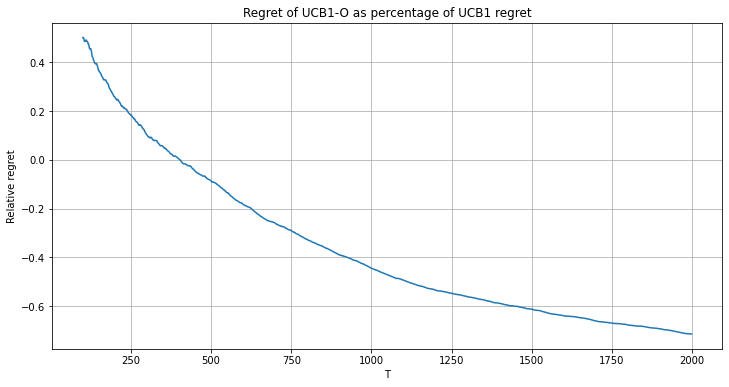

In [572]:
fig,axs=plt.subplots(figsize=(12, 6))
ts = np.arange(100, T)
plt.plot(ts, relative_regret)
plt.xlabel('T')
plt.ylabel('Relative regret')
plt.title('Regret of UCB1-O as percentage of UCB1 regret')
plt.grid();